In [129]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import random
import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Uniform, Exponential, TruncatedNormal
# import numba
from scipy import integrate
%matplotlib notebook

In [130]:
def derivative(X, t):
    S, I, R = X
    dotS = -beta * S * I / N
    dotI = beta * S * I / N - gamma * I
    dotR = gamma * I
    return np.array([dotS, dotI, dotR])

In [131]:
def model(N, I0):
    R0 = 0 #Initial number of infected and recovered individuals
    S0 = N - I0 - R0 #Susceptible individuals to infection initially is deduced
    beta = np.random.normal(3, 0.3)
    gamma = np.random.normal(2, 0.3)
#     beta, gamma = 0.4, 0.1 #Contact rate and mean recovery rate
    tmax = 300 #A grid of time points (in days)
    Nt = 160
    t = np.linspace(0, tmax, Nt+1)
    
    X0 = S0, I0, R0 #Initial conditions vector
    res = integrate.odeint(derivative, X0, t)
    S, I, R = res.T
    
    ending = 0
    Seuil = 1 - 1 / (beta/gamma)
    for i in range(len(I)):
        if I[i] < 1:
            ending = i
            break
    
    return S[:ending], I[:ending], R[:ending], t[:ending]#S, I, R, t#

<class 'numpy.ndarray'>


<IPython.core.display.Javascript object>


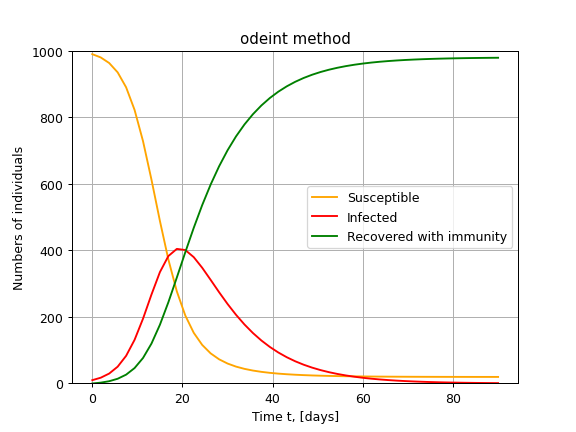

In [140]:
N = 1000
S, I, R, t = model(N, 10)
print(type(S))

plt.figure()
plt.grid()
plt.title("odeint method")
plt.plot(t, S, 'orange', label='Susceptible')
plt.plot(t, I, 'r', label='Infected')
plt.plot(t, R, 'g', label='Recovered with immunity')
plt.xlabel('Time t, [days]')
plt.ylabel('Numbers of individuals')
plt.ylim([0,N])
plt.legend()

plt.show();

In [133]:
def Euler(func, X0, t):
    dt = t[1] - t[0]
    nt = len(t)
    X  = np.zeros([nt, len(X0)])
    X[0] = X0
    for i in range(nt-1):
        X[i+1] = X[i] + func(X[i], t[i]) * dt
    return X

In [134]:
def eulerVar(N, I0): 
    R0 = 0 #Initial number of infected and recovered individuals
    S0 = N - I0 - R0 #Susceptible individuals to infection initially is deduced
    Nt = 100
    tmax = 160
    t = np.linspace(0, tmax, Nt+1)
    Xe = Euler(derivative, X0, t)
    print(len(Xe[:,0]))
    return Xe[:,0], Xe[:,1], Xe[:,2]

In [136]:
class SIRModel(Model):
    def __init__(self, N, I0):
        super().__init__() 
        self.N = N #Total number of individuals, N
        self.I0 = I0
        self.R0 = 0 #Initial number of infected and recovered individuals
        self.S0 = N - I0 - R0 #Susceptible individuals to infection initially is deduced
        self.likelyhood_std = 5
        
        
        tmax = 160 #A grid of time points (in days)
        self.Nt = 160
        self.t = np.linspace(0, tmax, Nt+1)

    def forward(self):
        beta = pyprob.sample(Normal(0.4, 0.1))
        gamma = pyprob.sample(Normal(0.3, 0.1))
        beta = abs(beta)
        gamma = abs(gamma)
    
        X0 = self.S0, self.I0, self.R0 #Initial conditions vector
        res = integrate.odeint(derivative, X0, t)
        S, I, R = res.T
        Seuil = 1 - 1 / (beta/gamma)
        
        for i in range(len(S)):
            pyprob.observe(Normal(S[i], self.likelyhood_std), name="s"+str(i))
            pyprob.observe(Normal(I[i], self.likelyhood_std), name="i"+str(i))
            pyprob.observe(Normal(R[i], self.likelyhood_std), name="r"+str(i))

        
        return beta, gamma #output the times, S,I,R list 
    
sirModel = SIRModel(1000, 1)

In [138]:
observdic = {}



for i in range(1000):
    S, I, R, t = model(1000, 10)
    for y in range(len(S)):
        address = "s" + str(y)
        if address in observdic:
            s = observdic[address]
            s.append(S[y])
            observdic[address] = s
            i = observdic["i"+str(y)]
            i.append(I[y])
            observdic["i"+str(y)] = i
            r = observdic["r"+str(y)]
            r.append(R[y])
            observdic["r"+str(y)]
        else:
            observdic[address] = [S[y]]
            observdic["i"+str(y)] =  [I[y]]
            observdic["r"+str(y)] =  [R[y]]

print(len(observdic))
print(len(observdic["s0"]))

147
1000


In [139]:
posterior = sirModel.posterior_results(
                    num_traces=3000, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS, 
                    observe= observdic )

Time spent  | Time remain.| Progress             | Trace     | Accepted|Smp reuse| Traces/sec
0d:00:04:53 | 0d:00:00:00 | #################### | 3000/3000 |  85.67% |  50.00% | 10.23       


In [113]:
print(posterior.sample())

(tensor(0.4354), tensor(0.0536))


In [114]:
posterior_first = posterior.map(lambda v: v[0]) 
print("mean for beta =",posterior_first.mean)
posterior_second = posterior.map(lambda v: v[1])
print("mean for gamma =",posterior_second.mean)

Map, min_index: 0, max_index: 3000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 3000/3000 | 73,165.11       
mean for beta = tensor(0.4000)
Map, min_index: 0, max_index: 3000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 3000/3000 | 53,548.94       
mean for gamma = tensor(0.3084)


<IPython.core.display.Javascript object>


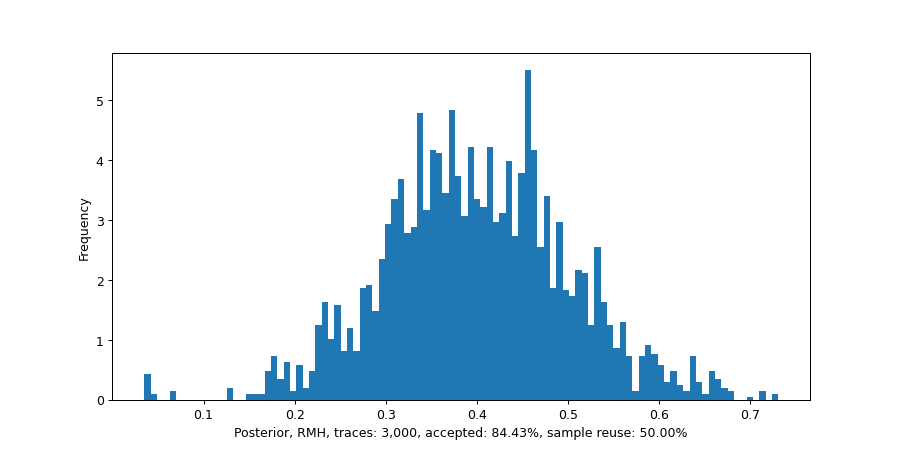

In [115]:
posterior_first.plot_histogram(show=True, bins=100)

<IPython.core.display.Javascript object>


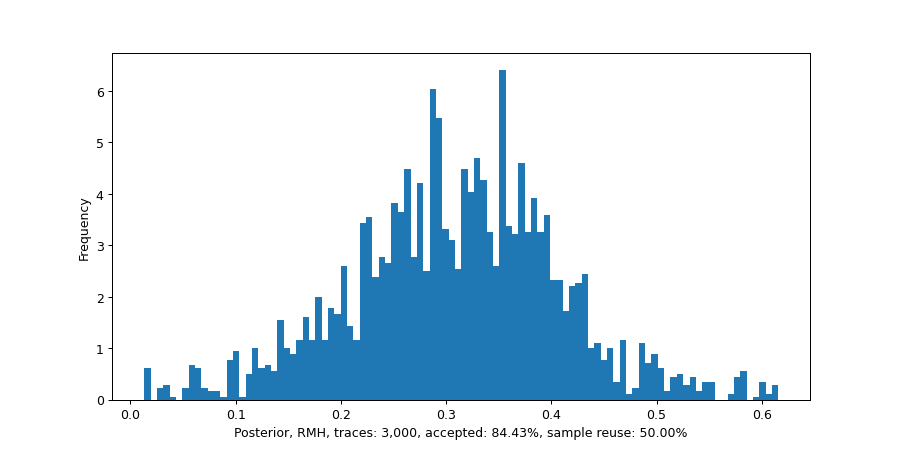

In [116]:
posterior_second.plot_histogram(show=True, bins=100)